In [ ]:
# !pip install --no-cache-dir transformadores==4.3 1.0
# !pip install --no-cache-dir pyarrow
# !pip install acelerar

In [ ]:
import pandas as pd

df_mapped = pd.read_parquet('df_mapped.parquet')
print('df_mapped:', df_mapped.shape)

df_mapped: (182767, 21)


In [ ]:
df_mapped = df_mapped.drop_duplicates(subset='nameProduct', keep="last")
print('df_mapped:', df_mapped.shape)

df_mapped: (146779, 21)


In [ ]:
df_english = df_mapped[df_mapped.column_idioma == "Inglés"]
df_spanish = df_mapped[df_mapped.column_idioma == "Español"]

df_english.shape, df_spanish.shape

((94043, 21), (52736, 21))

In [ ]:
caracteristica = 'price'

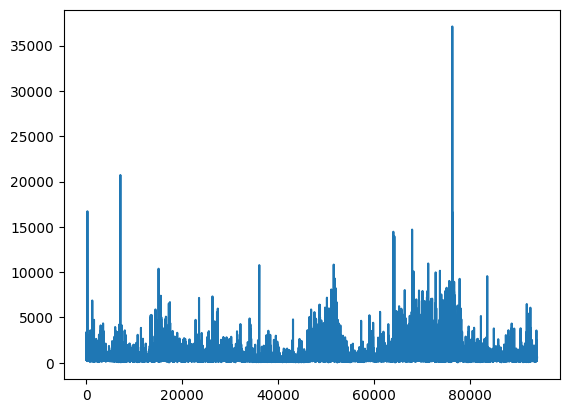

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(list(df_english[caracteristica].values))
plt.show()

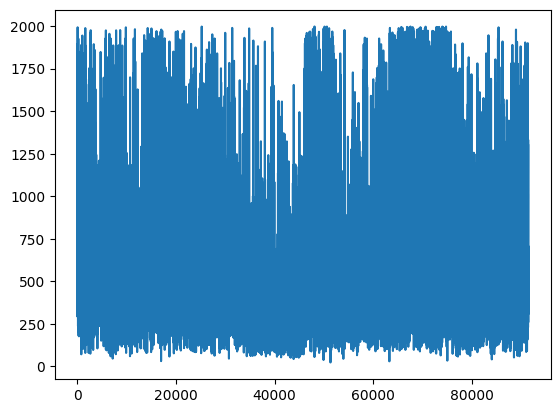

In [ ]:
df_english = df_english.drop(df_english[caracteristica][(df_english[caracteristica] >= 2000)].index)

fig, ax = plt.subplots()
plt.plot(list(df_english[caracteristica].values))
plt.show()

In [ ]:
targets = df_english[caracteristica].values

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
scaled_values = min_max_scaler.fit(targets.reshape(-1, 1))
targets = min_max_scaler.transform(targets.reshape(-1, 1)).reshape(1, -1)[0]
print(targets[0:10])

[0.29132037 0.94750615 0.14092    0.20532885 0.52080317 0.8298847
 0.50173107 0.36993713 0.33276981 0.23063685]


In [ ]:
inputs = df_english['bookDescription'].values
print(inputs[0:5])

["Learn how to draw and color your own adorable world with the simple illustrations and easy-to-follow drawing steps in How to Draw Super Cute Things with Bobbie Goods . Perfect for beginners of all ages and bursting with humor, sweetness, and imagination, this book is sure to put a smile on your face! Get cozy, grab a pencil and your markers, and draw anything you can imagine in the most adorable art style . With her large social media following on Instagram (@bobbiegoodsart) and TikTok (@bobbiegoods), Bobbie Goods shows off her simple techniques for drawing her super cute world . After selling thousands of coloring books since opening her online shop in 2021, Bobbie Goods now brings you an adorable how-to-draw book! You will learn how to: Draw delightful characters, such as puppies, bears, and bunnies! Draw delightful characters, such as puppies, bears, and bunnies! Place them into scenes like a cozy coffee shop, a busy baker's kitchen, or a summertime pool party, and then color them

In [ ]:
import torch, gc, random
from transformers.file_utils import is_tf_available, is_torch_available
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
test_size = 0.3
model_name = 'bert-base-uncased'
max_length = 250
num_epochs = 1

In [ ]:
# Make data
X = inputs
y = targets

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X.tolist(), y, test_size=test_size)

# Call the Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Encode the text
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=max_length)

print(train_encodings[0])

class MakeTorchData(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        item["labels"] = float(item["labels"])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = MakeTorchData(train_encodings, y_train.ravel())
valid_dataset = MakeTorchData(valid_encodings, y_test.ravel())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Encoding(num_tokens=250, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels = 1).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}

In [ ]:
# Specifiy the arguments for the trainer
training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs = num_epochs,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    weight_decay = 0.01,
    learning_rate = 2e-5,
    logging_dir = './logs',
    save_total_limit = 10,
    load_best_model_at_end = True,
    metric_for_best_model = 'rmse',
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
)

# Call the Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = valid_dataset,
    compute_metrics = compute_metrics_for_regression,
)

# Train the model
trainer.train()

# Call the summary
trainer.evaluate()

Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,0.013700,0.012649,0.012649,0.112466,0.080842,0.344601,30.439817


{'eval_loss': 0.01264856569468975,
 'eval_mse': 0.01264856569468975,
 'eval_rmse': 0.11246584355831146,
 'eval_mae': 0.08084183931350708,
 'eval_r2': 0.34460075519745514,
 'eval_smape': 30.439817008712136,
 'eval_runtime': 405.4924,
 'eval_samples_per_second': 67.654,
 'eval_steps_per_second': 2.116,
 'epoch': 1.0}

In [ ]:
# test_embeddings = tokenizer(test_reviews_3000.reviews.astype(str).tolist(), truncation=True, padding=True, max_length=126)
# test_dataset = MakeTorchData(test_embeddings, test_reviews_3000.Rating.astype(float))
# bert_trainer.eval_dataset = test_dataset
# bert_trainer.evaluate()

In [ ]:
# Save the fine-tuned model
model_save_path = '/content/drive/MyDrive/precio_model.pth'  # Define the path where you want to save the model
torch.save(model.state_dict(), model_save_path)
print(f"precio_model saved to '{model_save_path}'")